In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as dt
import pandas as pd 
import numpy as np
import torch.utils.data as data_utils
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'torch'

# Input and Hyperparameters #

In [3]:
data_path = "./US_length.csv"
learning_rate = 0.02
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
split = 0.8
batch_size = 50
num_epochs = 100
subset_val = None

# Data Cleaning #

In [4]:
df_main = pd.read_csv(data_path, sep = ',')
#subset data for testing ,use the first 10000
df = df_main[:subset_val] if (subset_val != None) else df_main
secs = df['sec'].values
mins = df['min'].values
hours = df['hour'].values
total_time = [s+60*m+3600*h for s,m,h in zip(secs, mins, hours)]
df['total_time'] = total_time
df_features=df[['title', 'total_time']]

In [5]:
#df_features['title_upper_count'] = df_features['title'].str.findall(r'[A-Z]').str.len()
df_features['tag_count'] = [len(s.split('|')) for s in df['tags'].values]
#df_features['category_id'] = df_main['category_id']
df_label = pd.DataFrame()
df_label['views'] = df['views']
df_features = df_features.drop(columns = 'title')

C:\Users\Charles\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
df_features.head()
df_features.describe()

,total_time,tag_count
count,30179.000000,30179.000000
mean,504.004308,19.453196
std,1521.821733,12.122659
min,0.000000,1.000000
25%,145.000000,9.000000
50%,260.000000,19.000000
75%,533.000000,28.000000
max,42909.000000,69.000000


In [7]:
df_label.head()
df_label.describe()


,views
count,3.017900e+04
mean,1.534091e+06
std,4.504928e+06
min,5.490000e+02
25%,1.663705e+05
50%,4.712660e+05
75%,1.301744e+06
max,1.493761e+08


# Setup Dataloader #

In [8]:
tv_split = int(len(df_features)*split)
train_set = df_features[:tv_split]
train_label = df_label[:tv_split]
validation_set = df_features[tv_split:]
validation_label = df_label[tv_split:]


In [9]:
class Dataset(dt.Dataset):
    def __init__(self, feature, labels):
        self.labels = labels
        self.feature = feature
    def __len__(self):
        return(len(self.feature))
    def __getitem__(self, idx):
        cur_feature = self.feature.iloc[idx]
        cur_feature = np.array(cur_feature)
        cur_label = self.labels.iloc[idx]
        cur_label = np.array(cur_label)
        sample = (cur_feature, cur_label)
        return sample

In [10]:
train = Dataset(train_set, train_label)
train_loader = data_utils.DataLoader(train, batch_size, shuffle = True)
test = Dataset(validation_set, validation_label)
test_loader = data_utils.DataLoader(test, batch_size, shuffle = True)

# Define Neural Network

In [11]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size).double() 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes).double()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        return out

# Main #

In [12]:
input_size = len(df_features.iloc[0])
output_size = len(df_label.columns)
hidden_size = int(np.ceil((input_size+output_size)/2))
model = NeuralNet(input_size, hidden_size, output_size).to(device)
# Loss and optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
# Train the model
total_step = len(train_loader)
loss = torch.tensor(0.0)
loss_list = []
for epoch in range(num_epochs):
    curr_epoch_loss = 0.0
    for i, (feature, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        # Move tensors to the configured device
        feature = torch.tensor(feature,  dtype = torch.float64).to(device)
        label = torch.tensor(labels,  dtype = torch.float64).to(device)

        # Forward pass/
        outputs = model(feature)
        loss = criterion(outputs, label)
        curr_epoch_loss+=loss.data.item()
        loss.backward()
        optimizer.step()
    print(curr_epoch_loss)
    print ('Epoch [{}/{}], Avg Loss: {:.1f}'.format(epoch+1, num_epochs, curr_epoch_loss/len(df_label)))
    loss_list.append(curr_epoch_loss)




C:\Users\Charles\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Charles\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


622892887.6699032
Epoch [1/100], Avg Loss: 20639.9
609992070.5846264
Epoch [2/100], Avg Loss: 20212.5
607099333.5325315
Epoch [3/100], Avg Loss: 20116.6
605277774.3028749
Epoch [4/100], Avg Loss: 20056.3
603352900.4056634
Epoch [5/100], Avg Loss: 19992.5
601311969.473702
Epoch [6/100], Avg Loss: 19924.8
599032859.3139006
Epoch [7/100], Avg Loss: 19849.3
596490075.1928757
Epoch [8/100], Avg Loss: 19765.1
593141547.0754435
Epoch [9/100], Avg Loss: 19654.1
589542898.8755862
Epoch [10/100], Avg Loss: 19534.9
585531577.7162497
Epoch [11/100], Avg Loss: 19402.0
581141390.5116351
Epoch [12/100], Avg Loss: 19256.5
577365588.2273768
Epoch [13/100], Avg Loss: 19131.4
574087992.3456806
Epoch [14/100], Avg Loss: 19022.8
571693130.2109158
Epoch [15/100], Avg Loss: 18943.4
569876617.7339683
Epoch [16/100], Avg Loss: 18883.2
568811625.8091606
Epoch [17/100], Avg Loss: 18847.9
568287469.9967456
Epoch [18/100], Avg Loss: 18830.6
568210002.2241621
Epoch [19/100], Avg Loss: 18828.0
568436212.1872141
Epoc

# Testing #

# Visualization #

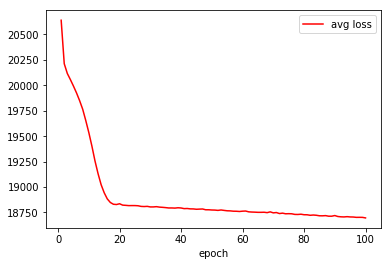

In [21]:
loss_avg = [i/len(df_label) for i in loss_list]
df_loss = pd.DataFrame()
df_loss['epoch'] = range(1,num_epochs+1)
df_loss['avg loss'] = loss_avg
df_loss
df_loss.plot(kind = 'line', x='epoch', y='avg loss', color = 'red')